TF Tutorial: https://www.tensorflow.org/tutorials/keras/regression

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [48]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.0


In [49]:
sensors = ['98F4AB39DB50', '98F4AB38C884', '4C11AEE82D80']
columns = ['CO2', 'VOC', 'RH', 'TEM', 'PM25', 'TIME', 'SCORE']

sensor = 1
csv = f"../{sensors[0]}-processed.csv"

In [50]:
raw_dataset = pd.read_csv(csv)
dataset = raw_dataset.copy()
dataset = dataset.drop('TIME', axis=1)

In [51]:
dataset.isna().sum()
dataset = dataset.dropna()

In [52]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

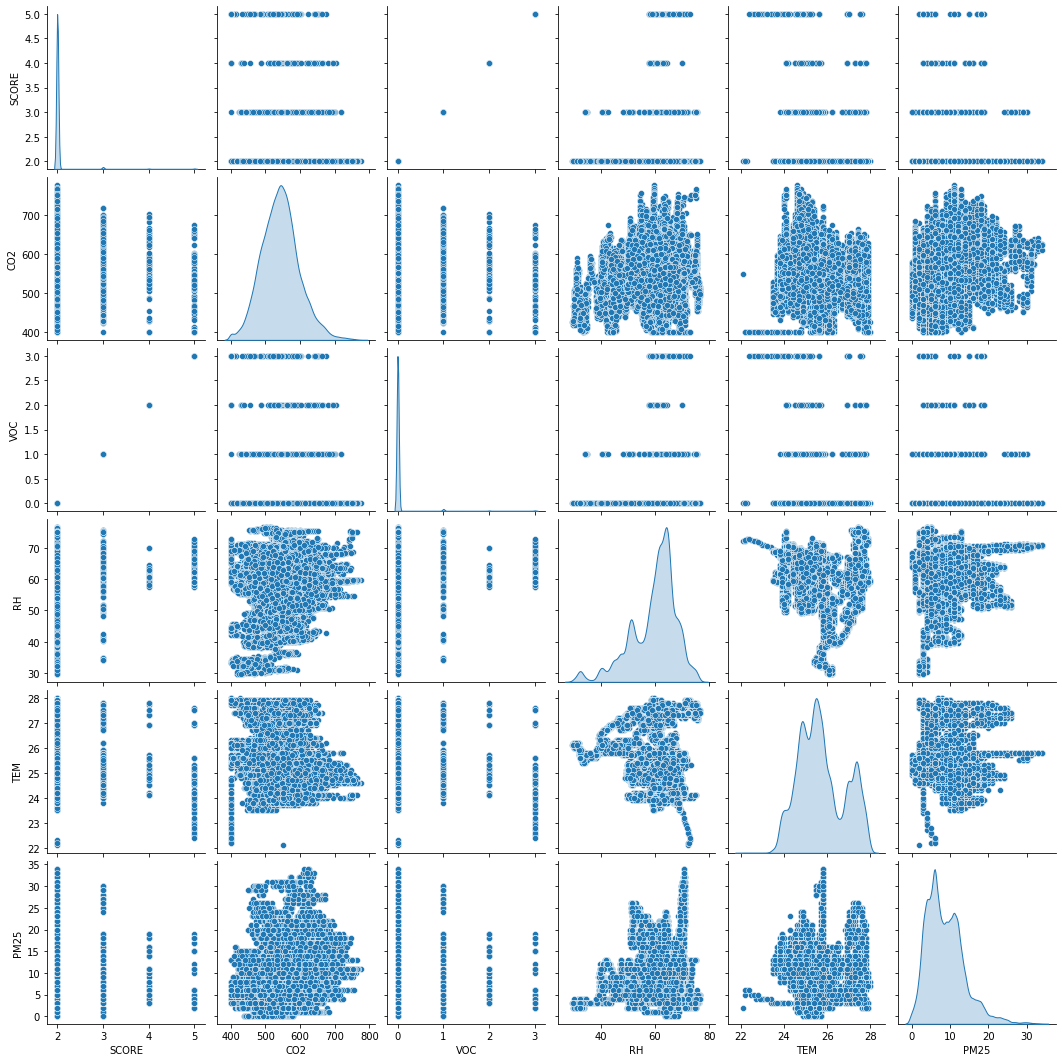

In [54]:
sns.pairplot(train_dataset[['SCORE', 'CO2', 'VOC', 'RH', 'TEM', 'PM25']], diag_kind='kde')


In [56]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CO2,54602.0,542.596938,54.314313,400.0,506.0,541.0,575.0,777.0
VOC,54602.0,0.022856,0.198319,0.0,0.0,0.0,0.0,3.0
RH,54602.0,59.503729,8.360565,29.6,54.8,61.4,64.9,76.7
TEM,54602.0,25.728466,1.058173,22.1,24.9,25.6,26.6,28.0
PM25,54602.0,8.710798,4.924358,0.0,5.0,8.0,12.0,34.0
SCORE,54602.0,2.022856,0.198319,2.0,2.0,2.0,2.0,5.0


In [59]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('SCORE')
test_labels = test_features.pop('SCORE')

In [61]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
CO2,542.596938,54.314313
VOC,0.022856,0.198319
RH,59.503729,8.360565
TEM,25.728466,1.058173
PM25,8.710798,4.924358
SCORE,2.022856,0.198319


In [64]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[542.596   0.023  59.504  25.728   8.711]]


In [66]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[551.    0.   62.8  24.    9. ]]

Normalized: [[ 0.15 -0.12  0.39 -1.63  0.06]]


Linear regression with multiple inputs

In [68]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [70]:
linear_model.predict(train_features[:10])

array([[-0.342],
       [ 0.015],
       [ 0.799],
       [ 0.414],
       [-0.119],
       [ 0.653],
       [ 0.818],
       [-0.513],
       [ 0.94 ],
       [ 0.817]], dtype=float32)

In [71]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(5, 1) dtype=float32, numpy=
array([[ 0.389],
       [-0.355],
       [ 0.511],
       [ 0.396],
       [ 0.043]], dtype=float32)>

In [72]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [73]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 1min 28s
Wall time: 1min 2s


In [75]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

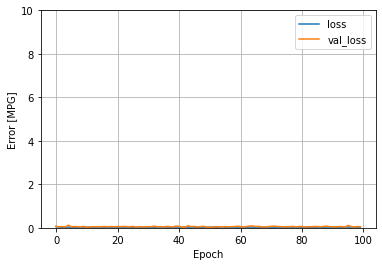

In [76]:
plot_loss(history)